<a href="https://colab.research.google.com/github/danielzt12/AD_LTEM/blob/main/AD_LTEM_sim_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [2]:
!git clone https://github.com/danielzt12/AD_LTEM

fatal: destination path 'AD_LTEM' already exists and is not an empty directory.


In [75]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import signal as tfs
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import sys, time
from scipy.fftpack import *
from skimage.restoration import unwrap_phase, denoise_tv_chambolle
from scipy import ndimage
from google.colab import output
import tifffile as tif
import gdown

sys.path.append("AD_LTEM")

from torch.cuda import get_device_name
print("GPU:", get_device_name(0))

GPU: Tesla T4


In [67]:
# truth for amplitude and phase

true_amplitude =  tif.imread('AD_LTEM/design_amp.tiff')
true_phase = tif.imread('AD_LTEM/design_tphi.tiff')

In [65]:
# load pre-generated data set, the stored values are the square root of the intensities already
noise = 10
# there are 65 defocus images equally distributed between -1.6 mm and 1.6 mm
defocus = np.linspace(-1.6e6,1.6e6,65)

if noise == 0:
  !gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
  A_samples = np.load("amplitude4TIE_noise0.npy")
elif noise == 5:
  !gdown "http://drive.google.com/uc?id=11X3ZvbEF3tuKV1hmYL_lDJIi1YShgms4"
  A_samples = np.load("amplitude4TIE_noise5.npy")
elif noise == 10:
  !gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
  A_samples = np.load("amplitude4TIE_noise10.npy")
elif noise == 14:
  !gdown "http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf"
  A_samples = np.load("amplitude4TIE_noise14.npy")
elif noise == 15:
  !gdown "http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l"
  A_samples = np.load("amplitude4TIE_noise15.npy")
elif noise == 20:
  !gdown "http://drive.google.com/uc?id=10tD8eOdh9MmTl5SpoetrMbWhN7lFz_iv"
  A_samples = np.load("amplitude4TIE_noise20.npy")
elif noise == 30:
  !gdown "http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca"
  A_samples = np.load("amplitude4TIE_noise30.npy")
elif noise == 40:
  !gdown "http://drive.google.com/uc?id=15yC64QAoWNDd6bSDd7_7lCa-Ic4ztgxA"
  A_samples = np.load("amplitude4TIE_noise40.npy")

print("estimated noise from transparent region : {0:.1f}%".format(A_samples[:,280:320,280:320].std()*200))

Downloading...
From: http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk
To: /content/amplitude4TIE_noise10.npy
136MB [00:00, 151MB/s]
estimated noise from flat region : 11.8%


Text(0.5, 1.0, '1600000.0 nm')

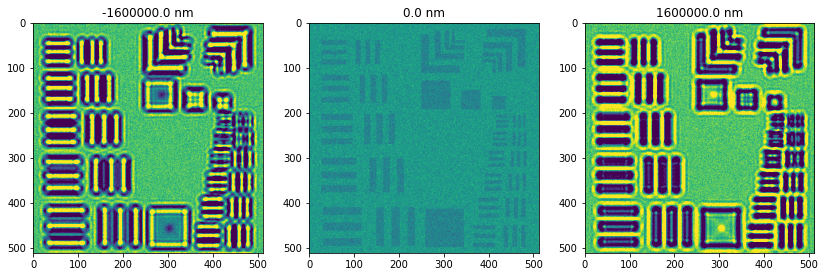

In [66]:
f, ax = plt.subplots(ncols=3, figsize = (14,8))
ax[0].imshow(A_samples[0], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[0].set_title("{0} nm".format(defocus[0]))
ax[1].imshow(A_samples[32], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[1].set_title("{0} nm".format(defocus[32]))
ax[2].imshow(A_samples[64], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[2].set_title("{0} nm".format(defocus[64]))

In [68]:
# generate microscopic transfer function

from microscopes_fwd import Microscope

defocus = np.linspace(-1.6e6,1.6e6,65)

#inititiate microscope class
TEM = Microscope(Cs = 1.0e6, theta_c = 0.01e-3, def_spr = 500)

#reciprocal space vectors
[dim,dim] = ampli_sample.shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

# define pixel resolution in nm.
del_px = 5 #nm/px

tf_microscope = np.zeros(A_samples.shape, dtype=np.complex64)
for i in range(defocus.shape[0]):
  TEM.defocus = defocus[i]
  tf_microscope[i] = TEM.getTransferFunction(qq, del_px)
  #A_samples[i] = np.abs((ifft2(tf_microscope[i]*fftshift(fft2(true_amplitude*np.exp(1j*true_phase))))))

#A_samples /= A_samples.mean(1).mean(1)[:,np.newaxis,np.newaxis]

In [74]:
selection = [28,30,62,64]
print("chosen defocus (mm): ", defocus[selection]/1e6)

TF = tf_microscope[selection]
exp_data = A_samples[selection]

chosen defocus (mm):  [-0.2 -0.1  1.5  1.6]


# Automatic Differentiation

In [76]:
# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = tf.constant(denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False), dtype='float32')
# initialize the phase as 0.5 everywhere
guess_phase = tf.Variable(np.zeros(A_samples[32].shape)+0.5, dtype='float32') 

In [ ]:
def compute_loss():
  tf_obj_real = intens*tf.math.cos(phase)
  tf_obj_imag = intens*tf.math.sin(phase)
  tf_obj = tf.complex(tf_obj_real, tf_obj_imag)

  guess_img = tfs.ifft2d(tfs.ifftshift(tfs.fftshift(tfs.fft2d(tf_obj))*tf_microscope, axes=(1,2)))

  guess_img = tf.abs(guess_img)
  guess_img /= tf.reduce_mean(guess_img, axis=(1,2), keepdims=True)
  #losses = tf.reduce_mean(tf.abs(guess_img - exp_img))
  losses = tf.reduce_mean((guess_img - exp_img)**2)#+ \
#            lamb2*tf.image.total_variation(tf.reshape(phase,[h,w,1]))
#           lamb1*tf.image.total_variation(tf.reshape(intens,[h,w,1]))+ 

  global gerr 
  gerr = losses
  return losses

def optiz(tol=1e-7, max_iter=100, lr=0.01):
  err = np.Inf # step error (banach), not actual erro
  i = 0
  #flag = 1
  errs = []
  accs = []
  acc0 = 0
  #print(lr)
  for i in (range(max_iter)):
    opt = tf.optimizers.Adam(learning_rate=lr)
    train = opt.minimize(compute_loss, var_list=[phase]) #Optim only over phase
    errs.append(gerr.numpy())
    ph_mean = phase.numpy()
    ph_mean -= ph_mean.mean()
    acc1 = (ph_mean*Ph_true_mean).sum() / np.sqrt((ph_mean*ph_mean).sum() * (Ph_true_mean*Ph_true_mean).sum())
    #if acc1<acc0 and flag:
    #  print(i, acc1)
    #  np.save(path+"AD_recons/tmp.npy", ph_mean)
    #  flag = 0
    accs.append(acc1)  #################
    acc0 = acc1
    i += 1

  #print ("Ran %d iterations" %i)
  return [intens.numpy(), phase.numpy()], errs, accs

In [ ]:
ttt = tif.imread('/content/drive/My Drive/new_test_data_for_ADLorentz/res_test_pattern/new_TIE_recons/'+'Stack_noise10_tphi-1.tif')[::-1]
#ttt = phase.numpy()
ttt -= ttt.mean()
Ph_true_mean = Ph_true-Ph_true.mean()
print((ttt*Ph_true_mean).sum() / np.sqrt((ttt*ttt).sum() * (Ph_true_mean*Ph_true_mean).sum()))

0.8893491


In [ ]:
path = '/content/drive/My Drive/new_test_data_for_ADLorentz/res_test_pattern/'
#path = '/content/drive/My Drive/res_test_pattern/'

A_sample =  tif.imread(path+'restest_design_amp.tiff')
Ph_true = tif.imread(path+'restest_design_tphi_nobckgrd.tiff')

tf_microscope = np.load(path+"tf_microscope.npy")[[26,28,30,64]]
A_samples = np.load(path+"amplitude4TIE_noise10.npy")[[26,28,30,64]]
#A_samples = np.load(path+"A_samples0.npy")[[34,36,38,64]]


#A_samples = np.load(path+"A_samples_noise20_defoc2.npy")

print(tf_microscope.shape, A_samples.shape)

truth = A_sample*np.exp(1j*Ph_true)
Ph_true_mean = Ph_true-Ph_true.mean()

(4, 512, 512) (4, 512, 512)


In [ ]:
exp_img = tf.constant(A_samples, dtype=tf.float32)
#intens = tf.constant(A_sample/A_sample.mean(), dtype='float32')
#intens = tf.constant(A_samples[0], dtype='float32')
intens = tf.constant(np.load(path+"denoise_tv_chambolle_A10.npy"), dtype='float32')
phase = tf.Variable(np.zeros(A_sample.shape)+0.5, dtype='float32')
##ttt = tif.imread(path+'TIE_recons/Stacknobg_nonoise_s512_tphi.tiff.tif')[::-1]
#ttt = np.load(path+"AD_recons/noise20_tv1e9_guess0p5_iter100000_phase_32.npy")
#phase = tf.Variable(Ph_true-Ph_true.mean(), dtype='float32')
#lamb1 = 1e-9 #Add TV minimization for intens
#lamb2 = 1e-7 #Add TV minimization for phase

In [ ]:
tot_errs = []
tot_accs = []
#phase = tf.Variable(phase, dtype='float32')

#lrs = [0.001,0.002,0.004,0.008,0.02,0.04,0.08,0.2,1]
lrs = [.8] #Use the best
for lr in lrs:
  tot_iters = 20000
  init_lr = lr
  t1=time.time()
  #
  result=optiz(1e-7,tot_iters,init_lr)
  t2=time.time()
  tot_errs += [result[1]]
  tot_accs += [result[2]]
  print(t2-t1)
  

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
print(tot_accs[0][-1])
print(np.array(tot_accs[0]).max())
print(np.array(tot_accs[0]).argmax())
print(tot_errs[0][np.array(tot_accs[0]).argmax()])

361.65003490448
0.9927751
0.99277514
19998
0.0020090146


In [ ]:

fig, ax = plt.subplots(1, figsize=(10,5))
x = np.linspace(1,tot_iters,tot_iters)
#for i in range(len(tot_errs)):
ax.plot(np.log10(np.array(tot_errs).flatten()))
  #ax[1].plot(x[int(0.8*tot_iters):], np.log10(tot_errs[i])[int(0.8*tot_iters):], label = '%.3f' %lrs[i])
ax.legend(title = 'Learning rate', loc='center right', bbox_to_anchor=(1.25, 0.5), prop={'size': 12})
#ax[1].set_ylim([-4.12,-4.0])
ax.set_xlabel("Iterations")
ax.set_ylabel("Log(mean squared error)")
#ax[1].set_xlabel("Iterations")
#ax[1].legend()

No handles with labels found to put in legend.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


0.97938776


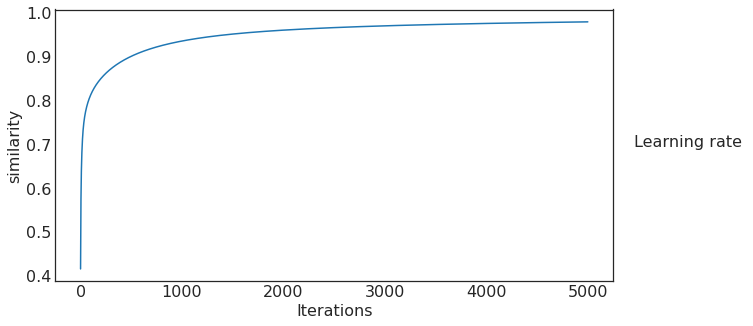

In [ ]:

fig, ax = plt.subplots(1, figsize=(10,5))
x = np.linspace(1,tot_iters,tot_iters)
for i in range(len(tot_accs)):
  ax.plot(np.array(tot_accs).flatten())
  #ax[1].plot(x[int(0.8*tot_iters):], np.log10(tot_errs[i])[int(0.8*tot_iters):], label = '%.3f' %lrs[i])
ax.legend(title = 'Learning rate', loc='center right', bbox_to_anchor=(1.25, 0.5), prop={'size': 12})
#ax[1].set_ylim([-4.12,-4.0])
ax.set_xlabel("Iterations")
ax.set_ylabel("similarity")
#ax[1].set_xlabel("Iterations")
#ax[1].legend()
print(np.array(tot_accs).max())

In [ ]:
print(np.array(tot_accs)[0][5000])

0.9737301


2.720035212467541 -2.3679903574482304


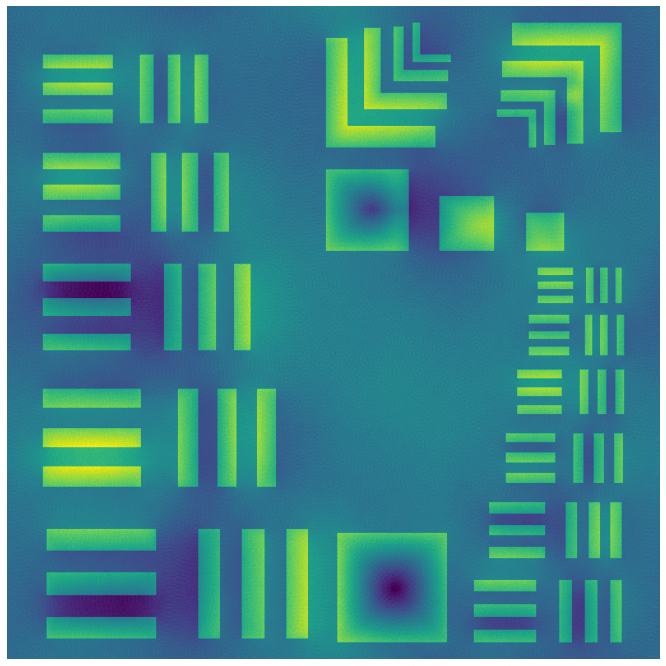

In [ ]:
f, ax = plt.subplots(figsize=(12,12))
phase2 = result[0][1]
tt = unwrap_phase(phase2)
ax.imshow(tt-tt.mean(), vmin=-2.12, vmax=2.67)#, interpolation='none')
print((tt-tt.mean()).max(), (tt-tt.mean()).min())
ax.set_axis_off()
#plt.savefig("/content/drive/My Drive/new_test_data_for_ADLorentz/paper/"+"fig8_8.png", dpi=None, facecolor='w', edgecolor='w',
#plt.savefig("/content/drive/My Drive/new_test_data_for_ADLorentz/new_paper/"+"noise5_064_5000iter_noisyamp.png", dpi=300, facecolor='w', edgecolor='w',
#        orientation='portrait', papertype=None, format=None,
#        transparent=False, bbox_inches="tight", pad_inches=0.1, metadata=None)

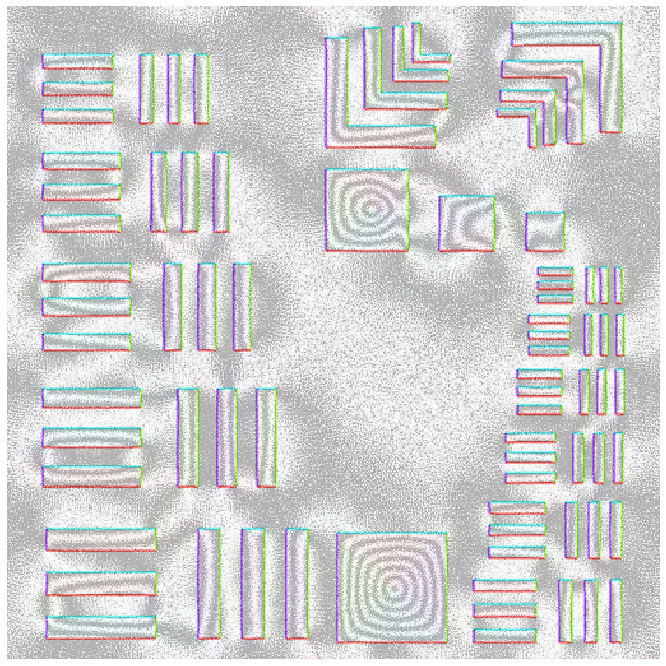

In [ ]:
tphi2=ndimage.gaussian_filter(tt-np.mean(tt),0,order=0)
gx=np.gradient(tphi2,axis=0)
gy=np.gradient(tphi2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
f, ax = plt.subplots(figsize=(12,12))
ax.imshow(rgb_map)
#ax.imshow(tt-tt.mean(), vmin=-2.12, vmax=2.67, interpolation='none', cmap='gray', alpha=0.3)
ax.imshow(np.cos(tphi2*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1, interpolation='none')
ax.set_axis_off()
#plt.savefig("/content/drive/My Drive/new_test_data_for_ADLorentz/paper/"+"fig8_8_grad.png", dpi=None, facecolor='w', edgecolor='w',
#plt.savefig("/content/drive/My Drive/new_test_data_for_ADLorentz/new_paper/"+"grad_noise5_2935_5000iter_noisyamp_f0.png", dpi=300, facecolor='w', edgecolor='w',
#        orientation='portrait', papertype=None, format=None,
#        transparent=False, bbox_inches="tight", pad_inches=0.1, metadata=None)

In [ ]:
np.savetxt("/content/drive/My Drive/new_test_data_for_ADLorentz/new_paper/"+"noise5_064_5000iter_noisyamp.txt", np.vstack([tot_accs[0], tot_errs[0]]).T)

In [ ]:
np.save("/content/drive/My Drive/new_test_data_for_ADLorentz/new_paper/"+"noise5_064_5000iter_noisyamp.npy", result[0][1])

(-0.1, 1.3)


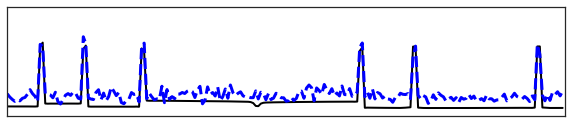

In [ ]:
def calc_mag(phase):
  grad_y, grad_x = np.gradient(phase)
  mag_x = grad_y
  mag_y = -1*grad_x
  mag_mag = (mag_x**2*0+mag_y**2)**0.5
  return mag_mag

fig, ax = plt.subplots(figsize=(10,2))
ax.plot(calc_mag(Ph_true)[457,205:425], 'k-', linewidth=2)

#ttt = tif.imread("/content/drive/My Drive/new_test_data_for_ADLorentz/res_test_pattern/new_TIE_recons/"+"Stack_noise20_olddef_tphi-1.tif")[::-1]
#ttt=ndimage.gaussian_filter(ttt-np.mean(ttt),0,order=0)
#ax.plot(calc_mag(ttt)[457,205:425], 'g--', linewidth=3)

#ttt = tif.imread("/content/drive/My Drive/new_test_data_for_ADLorentz/res_test_pattern/new_TIE_recons/"+"Stack_noise20_tphi-1.tif")[::-1]
#ttt -= ttt.mean()
#ax.plot(calc_mag(ttt)[457,205:425], '--', color="#EF8633", linewidth=3)

ttt = np.load("/content/drive/My Drive/new_test_data_for_ADLorentz/new_paper/"+"noise20_34366264_20000iter_noisyamp.npy")
ttt=ndimage.gaussian_filter(ttt-np.mean(ttt),0,order=0)
ax.plot(calc_mag(ttt)[454:460,205:425].mean(0), 'b--', linewidth=3)



ax.set_xlim(0, 220)
ax.set_ylim(-0.1, 1.3)
ax.set_xticklabels([])
ax.set_yticklabels([])
print(ax.get_ylim())

plt.savefig("/content/drive/My Drive/new_test_data_for_ADLorentz/new_paper/"+"figs5_cut3.png", dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches="tight", pad_inches=0.1, metadata=None)

'\nttt = np.load("/content/drive/My Drive/new_test_data_for_ADLorentz/new_paper/"+"noise10_3436_5000iter_noisyamp.npy")\nttt -= ttt.mean()\nax.plot(calc_mag(ttt)[457,205:425], \'b\')\n\nttt = np.load("/content/drive/My Drive/new_test_data_for_ADLorentz/new_paper/"+"noise14_34363864_5000iter_noisyamp.npy")\nttt -= ttt.mean()\nplt.plot(calc_mag(ttt)[457,205:425], \'orange\')\n\nttt = np.load("/content/drive/My Drive/new_test_data_for_ADLorentz/new_paper/"+"noise10_064_10kiter_noisyamp.npy")\nttt -= ttt.mean()\nplt.plot(calc_mag(ttt)[457,205:425], \'r\')\n\n\n'

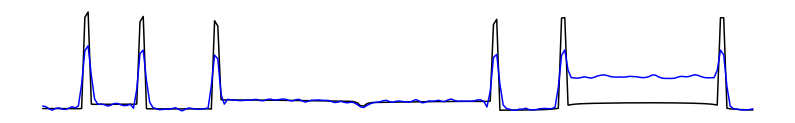

In [ ]:
f, ax = plt.subplots(figsize=(14,2))
ax.set_axis_off()
ax.plot(calc_mag(Ph_true)[457,205:425], 'k')
ax.plot(calc_mag(tphi2)[457,205:425], 'b')



"""
ttt = np.load("/content/drive/My Drive/new_test_data_for_ADLorentz/new_paper/"+"noise10_3436_5000iter_noisyamp.npy")
ttt -= ttt.mean()
ax.plot(calc_mag(ttt)[457,205:425], 'b')

ttt = np.load("/content/drive/My Drive/new_test_data_for_ADLorentz/new_paper/"+"noise14_34363864_5000iter_noisyamp.npy")
ttt -= ttt.mean()
plt.plot(calc_mag(ttt)[457,205:425], 'orange')

ttt = np.load("/content/drive/My Drive/new_test_data_for_ADLorentz/new_paper/"+"noise10_064_10kiter_noisyamp.npy")
ttt -= ttt.mean()
plt.plot(calc_mag(ttt)[457,205:425], 'r')


"""

#plt.savefig("/content/drive/My Drive/new_test_data_for_ADLorentz/new_paper/"+"fig3_cut_close_green.png", dpi=300, facecolor='w', edgecolor='w',
#        orientation='portrait', papertype=None, format=None,
#        transparent=False, bbox_inches="tight", pad_inches=0.1, metadata=None)


In [ ]:
data_in = numpy.load("/content/drive/My Drive/new_test_data_for_ADLorentz/new_paper/"+"noise10_2_100kiter_nonoiseamp.npy")

cen = [256, 256]
xxx = []
yyy = []
pp=3
pyplot.figure()
for r in range(400):
    data_out = []
    angle = numpy.linspace(0,2*numpy.pi,pp*r)
    for i in range(len(angle)):
        x = int(round(cen[0]+r*cos(angle[i]),0))
        y = int(round(cen[1]+r*sin(angle[i]),0))
        #print x,y
        if x>=512 or y>= 512:
            continue
        data_out += [data_in[y,x]]
        #data_in[y-5:y+5,x-5:x+5] = 0

    data_out = numpy.array(data_out)
    yy = numpy.abs(fft(data_out)[0:int(1.5*r)])
    #xx = numpy.linspace(0,1,3*r)[0:int(1.5*r)]

    #pyplot.figure()
    #pyplot.plot(data_out)
    #pyplot.figure()
    #pyplot.plot(yy)

    yymax = yy[5:].argmax()+5
    yyperiod = pp*r/yymax
    yydistance = 2*numpy.pi/pp/r*yyperiod*r*6
    #print r, yydistance
    xxx += [1/yydistance]
    #print yymax, r
    ##yyy += [data_out[numpy.argsort(data_out)][-1*int(pp*r/60)]-data_out[numpy.argsort(data_out)][int(pp*r/60)]]
    #data_out = data_out[:data_out.shape[0]/yymax*yymax]
    #data_norm = ((data_out.reshape(data_out.shape[0]/yymax, yymax).sum(1).reshape(data_out.shape[0]/yymax,1))*numpy.ones(yymax)).flatten()
    #data_out /= data_norm
    yyy += [data_out[numpy.argsort(data_out)][-5]-data_out[numpy.argsort(data_out)][5]]

xxx = numpy.array(xxx)

yyy = numpy.array(yyy)
yyy[xxx>0.03]=0
xxx[xxx>0.03]=0
yyy = yyy-yyy.min()
yyy = yyy/yyy.max()
print yyy.max(), xxx[yyy.argmax()]
pyplot.plot(xxx,yyy, '.')
    
pyplot.figure()
pyplot.imshow(data_in)





#pyplot.show()
#numpy.savetxt("test.txt", numpy.vstack((xxx,yyy)).T)


# Misc